In [2]:
import random
import numpy as np
from scipy import stats
import os
import subprocess
import pandas as pd
# from data.Autoencoder_Paper.Refactored_Autoencoder_Prototype_2 import Compressor_Autoencoder
import json
from collections import defaultdict

In [432]:
def split_file(path, x):
    with open(path, 'r') as file:
        lines = file.readlines()

    midpoint = int(len(lines) * x)

    with open(f"{path[:-4]}_train_{int(x * 100)}.txt", 'w') as file:
        for line in lines[:midpoint]:
            file.write(line)

    with open(f"{path[:-4]}_test_{int(x * 100)}.txt", 'w') as file:
        for line in lines[midpoint:]:
            file.write(line)

# Usage
# split_file(path_to_table+'/my_data.txt')

In [401]:
def save_file(file_name, vector):
    with open(file_name, 'w') as f:
        for num in vector:
            f.write(f'{num}\n')


def generate_random_and_save(file_name, num_elements=1000, low=0.001, high=2000):
    vector = np.random.uniform(low=low, high=high, size=num_elements)
    # Save the vector to a text file
    save_file(file_name, vector)
    # with open(file_name, 'w') as f:
    #     for num in vector:
    #         f.write(f'{num}\n')


def generate_normal_and_save(file_name, num_elements=1000, low=1, high=2000, mean=55, std_dev=500):
    vector = np.random.normal(loc=mean, scale=std_dev, size=num_elements)
    vector = np.clip(vector, low, high)

    # Save the vector to a text file
    save_file(file_name, vector)
    # with open(file_name, 'w') as f:
    #     for num in vector:
    #         f.write(f'{num}\n')


In [398]:
def get_vector(path_to_table, file_name):
    with open(os.path.join(path_to_table, file_name)) as f1, open(
        os.path.join(path_to_table, file_name + '.z.txt')) as f2:
        lines1 = f1.readlines()
        lines2 = f2.readlines()

    array1 = np.array([float(line) for line in lines1])
    array2 = np.array([float(line) for line in lines2])

    return array1, array2


def get_vector_one(path_to_table, file_name):
    with open(os.path.join(path_to_table, file_name)) as f1:
        lines1 = f1.readlines()
    array1 = np.array([float(line) for line in lines1])
    return array1


def min_normalize(vector):
    vector = np.array(vector)
    min_val = np.min(vector)
    max_val = np.max(vector)
    normalized_vector = (vector - min_val + 0.1)  #/ (max_val - min_val)
    return normalized_vector


def get_errors(nums1, nums2):
    diffs = []
    diff = np.abs(nums1 - nums2)
    diffs.append(diff)

    errors = {}

    MSE = np.mean(np.square(nums1 - nums2))
    errors["MSE"] = MSE

    mean_diff = np.mean([np.mean(diff) for diff in diffs])
    errors["Mean absolute difference"] = mean_diff

    rmse = np.sqrt(np.mean(np.square(nums1 - nums2)))
    errors["rmse"] = rmse

    # relative_error = np.abs(nums1 - nums2) / nums1
    # errors["relative error"] = relative_error

    # relative_absolute_error = np.abs(nums1 - nums2) / np.abs(nums1)
    # errors["relative absolute error"] = relative_absolute_error

    # percentage_error = 100 * (nums1 - nums2) / nums1
    # errors["percentage error"] = percentage_error

    mean_percentage_relative_error = 100 * np.mean(np.abs(nums1 - nums2) / nums1)
    errors["mean percentage relative error"] = mean_percentage_relative_error

    # norm_nums1 = min_normalize(nums1)
    # norm_nums2 = min_normalize(nums2)
    # normal_mpre = 100 * np.mean(np.abs(norm_nums1 - norm_nums2) / norm_nums1)
    # errors["normal mpre"] = normal_mpre

    return errors

In [758]:
def get_file_sizes(path_to_table, file_name):
    path = os.path.join('Autoencoder_Data/metadata_folder/', 'meta')

    file_names = [file_name, file_name + '.z', path + '.min', path + '.mod', path + '.str', path + '.dindex',
                  path + '.dvalue']
    file_sizes = []
    for name in file_names:
        file_path = os.path.join(path_to_table, name)
        if os.path.isfile(file_path):
            file_size = os.path.getsize(file_path)
            file_sizes.append((name, file_size))
    return file_sizes


def get_raw_size(path_to_file, file_name):
    return len(get_vector_one(path_to_file, file_name)) * 8

def get_file_sizes_rawcnt(path_to_table, file_name):
    path = os.path.join('Autoencoder_Data/metadata_folder/', 'meta')

    file_names = [file_name + '.z', path + '.min', path + '.mod', path + '.str', path + '.dindex',
                  path + '.dvalue']
    file_sizes = []

    file_sizes.append((file_name, get_raw_size(path_to_table, file_name)))

    for name in file_names:
        file_path = os.path.join(path_to_table, name)
        if os.path.isfile(file_path):
            file_size = os.path.getsize(file_path)
            file_sizes.append((name, file_size))
    return file_sizes


def get_compression_ratio(path_to_table, file_name):
    file_sizes = get_file_sizes(path_to_table, file_name)
    original_size = file_sizes[0][1]
    compressed_size = sum(x[1] for x in file_sizes[1:])
    return original_size / compressed_size

def get_compression_ratio_rawcnt(path_to_table, file_name):
    file_sizes = get_file_sizes_rawcnt(path_to_table, file_name)
    original_size = file_sizes[0][1]
    compressed_size = sum(x[1] for x in file_sizes[1:-2])
    return original_size / compressed_size


def get_compression_ratio_nodelta(path_to_table, file_name):
    file_sizes = get_file_sizes(path_to_table, file_name)
    original_size = file_sizes[0][1]
    compressed_size = sum(x[1] for x in file_sizes[1:-2])
    return original_size / compressed_size

In [441]:
def vector_stats(data):
    """
    Compute basic stats on a numeric vector
    """
    stats = {}
    stats['mean'] = np.mean(data)
    stats['median'] = np.median(data)
    stats['std'] = np.std(data)
    stats['min'] = np.min(data)
    stats['max'] = np.max(data)
    stats['25%'] = np.percentile(data, 25)
    stats['75%'] = np.percentile(data, 75)
    return stats


In [442]:
def get_bench(path_to_table, file_name):
    original, predicted = get_vector(path_to_table, file_name)
    benchmarks = {"errors": get_errors(original, predicted)}

    cr = get_compression_ratio(path_to_table, file_name)
    benchmarks["compression ratio"] = cr

    cr_nodelta = get_compression_ratio_nodelta(path_to_table, file_name)
    benchmarks["compression ratio no delta"] = cr_nodelta

    benchmarks["statistics original"] = vector_stats(original)
    benchmarks["statistics predicted"] = vector_stats(predicted)

    return benchmarks

In [542]:
# def run_test(path_to_table, file_name, test_config):
#   path_to_folder = "drive/My Drive/Some_random_stuff/data_stil/"
#   AutoencoderPy = "Refactored_Autoencoder_Prototype_3.py"
#   path_to_autoencoder = path_to_folder + "Autoencoder_Paper/" + AutoencoderPy

#   train_file = file_name + "_train.txt"
#   test_file = file_name + "_test.txt"

#   if test_config['do_train']:
#     !python "{path_to_autoencoder}" -r "{path_to_table}{train_file}" -q "{test_config['config.json']}"
#     print('\n=======================')
#   if test_config['do_compress']:
#     if test_config['error_bound'] != 0:
#       !python "{path_to_autoencoder}" -c "{path_to_table}{test_file}" -e {error} -q "{test_config['config.json']}"
#     else:
#       !python "{path_to_autoencoder}" -c "{path_to_table}{test_file}" -q "{test_config['config.json']}"
#     print('=======================')
#   if test_config['do_decompress']:
#     !python "{path_to_autoencoder}" -d "{path_to_table}{test_file}.z" -q "{test_config['config.json']}"
#     print('=======================')
#   if test_config['do_bench']:
#       return get_bench(path_to_table, test_file)

def run_test(path_to_table, file_name, test_config):
    path_to_folder = "data/"
    AutoencoderPy = "Refactored_Autoencoder_Prototype_4.py"
    path_to_autoencoder = path_to_folder + "Autoencoder_Paper/" + AutoencoderPy

    train_file = file_name + "_train_20.txt"
    test_file = file_name + "_test_20.txt"

    if test_config['do_train']:
        !python "{path_to_autoencoder}" -r "{path_to_table}{train_file}"
        print('\n=======================')
    if test_config['do_compress']:
        if test_config['error_bound'] is not None:
            !python "{path_to_autoencoder}" -c "{path_to_table}{test_file}" -e "{test_config['error_bound']}"
        else:
            !python "{path_to_autoencoder}" -c "{path_to_table}{test_file}"
        print('=======================')
    if test_config['do_decompress']:
        !python "{path_to_autoencoder}" -d "{path_to_table}{test_file}.z"
        print('=======================')
    if test_config['do_bench']:
        bench = get_bench(path_to_table, test_file)
        with open(
                f"{path_to_table}Autoencoder_Data/measurements_train_20_delta/statistics_{random.randint(1, 10000)}.json",
                "w") as f:
            json.dump(bench, f)
        return bench

# def run_test(path_to_table, file_name, test_config):
#     autoencoder_config = {"config" : "autoencoder_config.json",
#                           'training' : None,
#                           'compress' : None,
#                           'decompress' : None,
#                           'transfer' : None,
#                           'error' : None,
#                           'output_error' : None
#                           }
#     autoencoder = Compressor_Autoencoder(autoencoder_config)
#
#     train_file = file_name + "_train.txt"
#     test_file = file_name + "_test.txt"
#
#     if test_config['do_train']:
#         autoencoder.args['training'] = f'{path_to_table}/{train_file}'
#         autoencoder.run()
#         autoencoder.args['training'] = None
#     if test_config['do_compress']:
#         autoencoder.args['compress'] = f'{path_to_table}/{test_file}'
#         if test_config['error_bound'] != 0:
#             autoencoder.args['error_bound'] = test_config['error_bound']
#             autoencoder.run()
#         else:
#             autoencoder.run()
#         autoencoder.args['compress'] = None
#     if test_config['do_decompress']:
#         autoencoder.args['decompress'] = f'{path_to_table}/{test_file}.z'
#         autoencoder.run()
#
#     test_info = get_bench(path_to_table, test_file)
#
#     with open(f"{path_to_table}/info.json", "w") as f:
#         json.dump(test_info, f)
#     return test_info

In [530]:
# path_to_folder = "data/"
# compress_config = {
#         'error_bound' : None,
#         'do_train' : True,
#         'do_compress' : True,
#         'do_decompress' : True,
#         'do_bench' : True,
#         'config.json' : path_to_folder + 'Autoencoder_Config/autoencoder_config.json'
#     }
#
# for i in range(3):
#     run_test(path_to_folder+ "table_0_smoke_detection/" +"random/", 'random', compress_config)

In [444]:
# generate_random_and_save(path_to_folder+"table_5_my_table_random/random_train.txt", num_elements=20000)
# generate_random_and_save(path_to_folder+"table_5_my_table_random/random_test.txt", num_elements=20000)

# generate_normal_and_save(path_to_folder+"table_6_my_table_normal/normal_train.txt", num_elements=15000)
# generate_normal_and_save(path_to_folder+"table_6_my_table_normal/normal_test.txt", num_elements=15000)

# 1.add printing logs to some file
# table_name | Benchmarks | Autoencoder Config | Normalization Function | time
# 3. finish table_compression function

In [445]:
def get_clean_col(col, na_values=[np.nan]):
    # Track NaN ranges
    value_ranges = []
    value_start = None

    clean_col = []
    for i, val in enumerate(col):
        if not pd.isna(val):
            clean_col.append(val)
            if value_start is None:
                value_start = i
        else:
            if value_start is not None:
                value_ranges.append((value_start, i - value_start))
                value_start = None
    return clean_col, value_ranges


def extract_and_write_column(table_path, col_name, numeric_cols, na_values):
    # Create folder for this column
    folder_path = f"{table_path}/{col_name}"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    col = numeric_cols[col_name].values
    clean_col, nan_ranges = get_clean_col(col, na_values)

    # Write clean column and NaN metadata
    np.savetxt(f"{folder_path}/{col_name}.txt", clean_col)
    np.savetxt(f"{folder_path}/{col_name}_nan_meta.txt", nan_ranges)


def restore_nas(column_path):
    if not os.path.exists(column_path + ".txt.z.txt"):
        print("decompressed file don't exists!")
        return

    clean_col = np.loadtxt(f'{column_path}.txt.z.txt')
    nan_meta = np.loadtxt(f'{column_path}_nan_meta.txt')
    restored = np.copy(clean_col)

    for i in range(0, len(nan_meta)):
        restored = np.insert(restored, int(nan_meta[i][0]), np.zeros(int(nan_meta[i][1])))

    np.savetxt(f"{column_path}_restored.txt", restored)


def compress_table(table_path, table_name, table_config, compress_config):
    df = pd.read_csv(os.path.join(table_path, table_name), na_values=table_config['na_values'])
    if table_config['columns'] is not None:
        df = df[table_config['columns']]
    numeric_cols = df.select_dtypes(include=[np.number])

    bench = {}
    for col_name in numeric_cols:
        folder_path = os.path.join(table_path, col_name)
        print(folder_path, col_name)

        if table_config['do_write']:
            extract_and_write_column(table_path, col_name, numeric_cols, table_config['na_values'])
            split_file(f"{folder_path}/{col_name}.txt", 0.5)

        # Compress the text file
        bench[col_name] = run_test(f"{folder_path}/", col_name, compress_config)
        # restore_nas(f"{folder_path}/{col_name}", numeric_cols[col_name].size, table_config['na_values'])
    return bench

In [446]:
info_attempts = defaultdict(list)
folder_name = ["table_0_smoke_detection/", "table_test_2/", "table_test_3/", "table_test_4/", "table_test_5/"]
table_name = ["smoke_detection_iot.csv", "RICE_2.csv", "ds_salaries_3.csv", "Plant_2_Generation_Data_4.csv",
              "realtor-data_5.csv"]
columns = [
    ["Humidity[%]", "TVOC[ppb]", "eCO2[ppm]", "Raw H2", "Raw Ethanol", "Pressure[hPa]", "PM1.0", "PM2.5", "NC0.5",
     "NC1.0", "NC2.5", "CNT", "Fire Alarm"],
    ['Observation Year', 'Standard Week', 'Pest Value', 'MaxT', 'MinT', 'RH1(%)', 'RH2(%)', 'RF(mm)', 'WS(kmph)',
     'SSH(hrs)', 'EVP(mm)'],
    ['work_year', 'salary', 'salary_in_usd', 'remote_ratio'],
    ['PLANT_ID', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD'],
    ['house_size', 'zip_code', 'acre_lot', 'price', 'bed', 'bath']
]

base_columns = ['Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw H2', 'PM2.5', 'NC2.5', 'CNT', 'random']

path_to_folder = "data/"

for ind in range(0, 1):  #len(folder_name)):
    table_config = {
        'do_write': True,
        'columns': columns[ind],
        'na_values': [0, np.nan]
    }

    compress_config = {
        'error_bound': None,
        'do_train': True,
        'do_compress': True,
        'do_decompress': True,
        'do_bench': True,
        'config.json': path_to_folder + 'Autoencoder_Config/autoencoder_config.json'
    }

    # for i in range(3):
    #     info = compress_table(path_to_folder+folder_name[ind], table_name[ind],
    #                table_config, compress_config)
    #     info_attempts[table_name[ind]].append(info)

    # with open(path_to_folder + folder_name[ind] + "statistics_batch_8.json", "w") as f:
    #     json.dump(info_attempts, f)

In [438]:
def sort_data_test(path_to_file, file_name):
    data = get_vector_one(path_to_file, file_name + "_test.txt")
    data.sort()
    save_file(path_to_file + file_name + "_test_sorted.txt", data)


def sort_data_train(path_to_file, file_name):
    data = get_vector_one(path_to_file, file_name + "_train_20.txt")
    data.sort()
    save_file(path_to_file + file_name + "_train_20_sorted.txt", data)


In [771]:
import zstandard as zstd

def compress_file(filepath, level = 10):
  """Compress file using zstd"""

  # Compress
  cctx = zstd.ZstdCompressor(level=level)
  with open(filepath, 'rb') as input_f:
    with open(filepath + '2.zst', 'wb') as output_f:
      cctx.copy_stream(input_f, output_f)

  print(f'{filepath} compressed to {filepath}2.zst')

In [772]:
compress_file("data/table_0_smoke_detection/random/random_test_20.txt", 22)

data/table_0_smoke_detection/random/random_test_20.txt compressed to data/table_0_smoke_detection/random/random_test_20.txt2.zst


In [774]:
for column in base_columns:
    print(column)
    compress_file(f"data/table_0_smoke_detection/{column}/{column}_test_20.txt", 22)
    # sort_data_test("data/"+folder_name[0]+ column +"/", column)
    # sort_data_train("data/" + folder_name[0] + column + "/", column)
    # split_file(f"data/{folder_name[0]}{column}/{column}.txt", 0.2)

Humidity[%]
data/table_0_smoke_detection/Humidity[%]/Humidity[%]_test_20.txt compressed to data/table_0_smoke_detection/Humidity[%]/Humidity[%]_test_20.txt2.zst
TVOC[ppb]
data/table_0_smoke_detection/TVOC[ppb]/TVOC[ppb]_test_20.txt compressed to data/table_0_smoke_detection/TVOC[ppb]/TVOC[ppb]_test_20.txt2.zst
eCO2[ppm]
data/table_0_smoke_detection/eCO2[ppm]/eCO2[ppm]_test_20.txt compressed to data/table_0_smoke_detection/eCO2[ppm]/eCO2[ppm]_test_20.txt2.zst
Raw H2
data/table_0_smoke_detection/Raw H2/Raw H2_test_20.txt compressed to data/table_0_smoke_detection/Raw H2/Raw H2_test_20.txt2.zst
PM2.5
data/table_0_smoke_detection/PM2.5/PM2.5_test_20.txt compressed to data/table_0_smoke_detection/PM2.5/PM2.5_test_20.txt2.zst
NC2.5
data/table_0_smoke_detection/NC2.5/NC2.5_test_20.txt compressed to data/table_0_smoke_detection/NC2.5/NC2.5_test_20.txt2.zst
CNT
data/table_0_smoke_detection/CNT/CNT_test_20.txt compressed to data/table_0_smoke_detection/CNT/CNT_test_20.txt2.zst
random
data/table_

In [545]:
# for i in range(3):
#     for column in base_columns:
#         compress_config = {
#             'error_bound' : 0.01,
#             'do_train' : True,
#             'do_compress' : True,
#             'do_decompress' : True,
#             'do_bench' : True,
#             'config.json' : path_to_folder + 'Autoencoder_Config/autoencoder_config.json'
#         }
#         run_test(f"data/{folder_name[0]}{column}/", column, compress_config)

In [658]:
# 1. Search for dependency in distribution of 20% of data
# 2. Another way to calculate the CR
# 3. Search for better solutions

In [ ]:
import os
import sys
import subprocess
import numpy as np

# Exact data:
n = 1000000
zexact = np.random.randn(n)

# Settings:
pwre = 1e-7
filename = 'zexact.dat'

# Write the data to a file, call the SZ compressor and decompressor via the
# command line and reload.
zexact.tofile(filename)
subprocess.run(['sz', '-z', '-d', '-M', 'PW_REL', '-P', f'{pwre:.2E}', '-i', filename, '-1', str(n)], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
subprocess.run(['sz', '-x', '-d', '-s', filename+'.sz', '-1', str(n)], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)

z_sz = np.fromfile(filename+'.sz.out')
ratio_sz = zexact.nbytes / os.path.getsize(filename+'.sz')
pwre_sz = np.max(np.abs(zexact - z_sz) / np.abs(zexact))

print(f'Compression ratio for command line SZ: {ratio_sz:.2}')
print(f'Pointwise relative error for command line SZ: {pwre_sz:.2e}\\n')

In [835]:
import json
import csv
import glob

def create_csv_from_json(json_paths, csv_path):
    # Define the fieldnames for the CSV file
    fieldnames = ['column_name','rmse', 'mean', 'median', "mean percentage relative error"]

    # Open the CSV file in write mode
    with open(csv_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Write the header to the CSV file
        writer.writeheader()

        # Loop over each JSON file path
        for path in json_paths:
            # Open the JSON file and load the data
            with open(path, 'r') as jsonfile:
                data = json.load(jsonfile)

            # Write the data to the CSV file
            row = {}
            row["column_name"] = path.split("/")[2]
            row["mean percentage relative error"] = data["errors"]["mean percentage relative error"]
            row["rmse"] = data["errors"]["rmse"]
            row["mean"] = data["statistics original"]["mean"]
            row["median"] = data["statistics original"]["median"]


            writer.writerow(row)

# Usage:

measurement_type = ['measurements_train_with_20', 'measurements_batch_8']
for m_type in measurement_type:
    json_paths = []
    for column in base_columns:
        json_path = f"data/table_0_smoke_detection/{column}/Autoencoder_Data/{m_type}/"
        files = glob.glob(os.path.join(json_path, '*'))
        for dir in os.listdir(json_path):
            if dir.startswith("statistics_"):
                json_paths.append(json_path +  dir)
                break
        # print(json_path)
    create_csv_from_json(json_paths, f"data/table_0_smoke_detection/_graphics/{m_type}_table.csv")


In [837]:
import math

def normalize_data(data_num):
    data_num_size = len(data_num)  # The number of data points in the input file

    modifications_all = [
                            0] * data_num_size  # This list should store the number of times that each number in the dataset was multiplied or divided by 10

    # Go through each element in the dataset
    for i in range(data_num_size):
        try:
            modifications_all[i] = (math.floor(math.log10(data_num[
                                                              i])) + 2) * -1  # Note: If using a version of Python where math.floor does not return an int, then the return value of math.floor may need to be explicitly converted to an int before making further computations

        # If a ValueError is raised, assume the current value is 0. Set modifications_all[i] to 0 (indicating that this number was not multiplied or divided by 10)
        except ValueError:
            modifications_all[i] = 0

    # Using the previously generated modifications_all list, multiply (or, when modifications_all[i] is negative, divide) the values in data_num to ensure that they are either 0 or in the range [0.01, 0.1)
    data_num = [data_num[i] * (10 ** modifications_all[i]) for i in range(data_num_size)]

    # In order to make the modifications list more space-efficient, make it so that it does not contain any consecutive numbers
    # Instead, each non-repeating number will be stored in modifications, and the number of times that that value appears consecutively in modifications_all will be in strides
    # For example, if modifications_all is [3, 3, 3, 4, 5, 5, 5, 5], then the updated modifications will be [3, 4, 5] strides will be [3, 1, 4] (representing the number of times that each value of modifications_all repeats consecutively)
    modifications = []
    strides = []
    index = -1
    last_num = 0.5  # Compare each element in modification_value to the previous element (stored in last_num); intialize last_num to 0.5 to avoid confusion at the beginning because each modification value should be an integer, so comparing to 0.5 should return False
    mod_min = modifications_all[0]

    # Utilize the strides list to prevent the same number being stored next to itself in the modifications array
    for i in range(data_num_size):
        # If the modification value of the current index was the same as that of the previous index, then increment the strides that the previous index used by 1
        if modifications_all[i] == last_num:
            strides[index] += 1
        # If the modification value of the current index is different from that of the previous index, then add the value to modifications, set the strides at that value to be 1, update last_num, and increment the index (tracks the index of modifications and strides)
        else:
            modifications.append(modifications_all[i])
            strides.append(1)
            last_num = modifications_all[i]
            index += 1

            # If the current value is less than the value of mod_min, then update mod_min to the current value
            if (modifications_all[i] < mod_min):
                mod_min = modifications_all[i]

    # Find the minimum value of modifications and, if it is negative, increment all the values in modifications by the absolute value of that number so that every value in modifications is 0 or positive
    if mod_min < 0:
        for i in range(index + 1):
            modifications[i] += (mod_min * -1)

    return data_num, data_num_size, modifications, strides, mod_min, index


In [841]:
normalize_data([60,20,5000,46])

([0.06, 0.02, 0.05, 0.046], 4, [2, 0, 2], [2, 1, 1], -5, 2)

Data Visualization

In [777]:
def get_mpre(xxx):
    mean_value = 0
    cnt = 0

    for dir in os.listdir(xxx):
        if dir.startswith("statistics_"):
            cnt += 1
            with open(xxx + dir, 'r') as f:
                mean_value += json.load(f)['errors']['mean percentage relative error']
    mean_value /= cnt
    return mean_value


def get_cr(xxx):
    mean_value = 0
    cnt = 0

    for dir in os.listdir(xxx):
        if dir.startswith("statistics_"):
            cnt += 1
            with open(xxx + dir, 'r') as f:
                mean_value += json.load(f)['compression ratio']
    mean_value /= cnt
    return mean_value


def get_cr_nodelta(xxx):
    mean_value = 0
    cnt = 0

    for dir in os.listdir(xxx):
        if dir.startswith("statistics_"):
            with open(xxx + dir, 'r') as f:
                data = json.load(f)
                if "compression ratio no delta" in data.keys():
                    cnt += 1
                    mean_value += data['compression ratio no delta']
    return mean_value / cnt if cnt > 0 else mean_value


def get_cr_zstd(xxx):
    return os.path.getsize(xxx) / os.path.getsize(xxx+".zst")

def get_cr_zstd2(xxx):
    return os.path.getsize(xxx) / os.path.getsize(xxx+"2.zst")

In [778]:
def get_table_stats(table_name, measurement_path, column_names):
    path_to_folder = "data/"
    result = {}
    for column_name in column_names:
        xxx = f"{path_to_folder}{table_name}{column_name}/{measurement_path}"
        result[column_name] = [get_mpre(xxx), get_cr(xxx), get_cr_nodelta(xxx), get_cr_zstd(f"{path_to_folder}{table_name}{column_name}/{column_name}_test_20.txt"), get_compression_ratio_rawcnt(f"{path_to_folder}{table_name}{column_name}/", f"{column_name}_test_20.txt"), get_cr_zstd2(f"{path_to_folder}{table_name}{column_name}/{column_name}_test_20.txt")]
    return result

In [779]:
get_table_stats(folder_name[0], "Autoencoder_Data/measurements_batch_4_train_20/", base_columns)

{'Humidity[%]': [12.933017786542267,
  161.92715972653824,
  826.0646797717185,
  11.040425784361917,
  254.17374762206722,
  21.199414157851912],
 'TVOC[ppb]': [41.85670191458791,
  65.29073482428115,
  96.59790778767918,
  15.93827192062802,
  29.722433165439753,
  28.05247760925334],
 'eCO2[ppm]': [8.333782030915701,
  142.88735329604037,
  491.77198942997364,
  22.761413869620675,
  151.3144582861457,
  68.15800763877989],
 'Raw H2': [2.5565248364969375,
  161.92715972653824,
  826.0646797717185,
  17.750912955796586,
  254.17374762206722,
  37.249914217087955],
 'PM2.5': [24.219785989913845,
  122.28533809837297,
  311.290399808475,
  11.73541038646907,
  95.78166147953077,
  31.837124458264977],
 'NC2.5': [21.176571835054087,
  122.89881908360888,
  315.06030515863404,
  15.609546550834544,
  96.94163235650278,
  54.01669227255741],
 'CNT': [13.496342076606902,
  159.22258892555922,
  760.4203152364274,
  63.99724869804461,
  233.9754816112084,
  239.18472273228056],
 'random': [

In [767]:
import matplotlib.pyplot as plt


def build_plot_re(data):
    # data = get_table_stats(table_name, column_names)
    names = list(i[0] for i in data.keys())
    values = list(i[0] for i in data.values())

    plt.bar(names, values)
    plt.title('relative error')
    plt.xlabel('Name')
    plt.ylabel('Ratio')
    plt.show()


def build_plot_cr(data):
    names = list(i[4] for i in data.keys())
    values = list(i[4] for i in data.values())

    plt.bar(names, values)
    plt.title('compression ratio')
    plt.xlabel('Name')
    plt.ylabel('Ratio')
    plt.show()

In [612]:
import matplotlib.pyplot as plt
import numpy as np


def plot_batch_comparison(ind):
    data = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements/", base_columns)

    data1 = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements/", base_columns)
    data2 = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements_batch_8/", base_columns)
    data3 = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements_train_with_20/", base_columns)
    data4 = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements_sorted_train_with_20/", base_columns)
    data5 = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements_train_20_delta/", base_columns)
    # data5 = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements_batch_8/", base_columns)
    # data4 = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements_train_with_20/", base_columns)
    # data5 = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements_batch_4_train_20/", base_columns)
    # data6 = get_table_stats(folder_name[ind], "AutoEncoder_Data/measurements_sorted/", base_columns)

    names = list(data1.keys())
    values0 = list(i[0] for i in data1.values())
    values1 = list(i[0] for i in data2.values())
    values2 = list(i[0] for i in data3.values())
    values3 = list(i[0] for i in data4.values())
    values4 = list(i[0] for i in data5.values())
    # values4 = list(i[0] for i in data4.values())
    # values5 = list(i[0] for i in data5.values())
    # values6 = list(i[0] for i in data6.values())
    # values7 = list(i[0] for i in data7.values())

    x = np.arange(len(names))
    width = 0.4

    fig, ax = plt.subplots()
    # rects0 = ax.bar(x, values0, width, label='Batch = 64. Default')
    # rects1 = ax.bar(x + width, values1, width, label='Batch = 8')
    # rects2 = ax.bar(x + 2*width, values2, width, label='Batch = 8. Train on 20%')
    # rects3 = ax.bar(x +3*width, values3, width, label='Batch = 8. Train on 20% + sorted')
    rects4 = ax.bar(x, values4, width, label='Batch = 8. 20% + sorted. delta = 0.01')
    # rects4 = ax.bar(x + 2*width, values4, width, label='Batch = 8. Train = 20%')
    # rects5 = ax.bar(x + 3*width, values5, width, label='Batch = 4. Train = 20%')
    # rects6 = ax.bar(x + 4*width, values6, width, label='Batch = 8. Train Sorted ')
    # rects7 = ax.bar(x + 3*width, values7, width, label='Batch = 8. Train Sorted. Test not')

    ax.set_ylabel('Relative Error')
    ax.set_title('Relative Error by Batch size')
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.legend()

    fig.tight_layout()
    plt.show()

    print(data.keys())

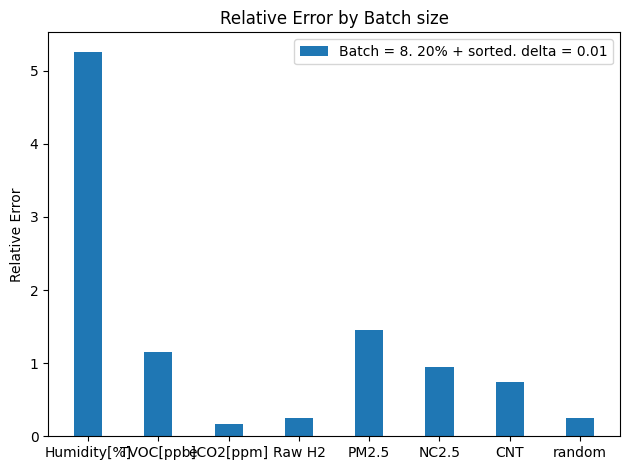

dict_keys(['Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw H2', 'PM2.5', 'NC2.5', 'CNT', 'random'])


In [613]:
plot_batch_comparison(0)

In [768]:
import matplotlib.pyplot as plt
import numpy as np


def plot_batch_comparison_cr(ind):
    data = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements/", base_columns)

    data1 = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements_train_20_delta/", base_columns)
    # data2 = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements_batch_32/", base_columns)
    # data3 = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements_batch_16/", base_columns)
    # data4 = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements_batch_8/", base_columns)
    # data5 = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements_batch_8/", base_columns)
    # data4 = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements_train_with_20/", base_columns)
    # data5 = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements_batch_4_train_20/", base_columns)
    # data6 = get_table_stats(folder_name[ind], "AutoEncoder_Data/measurements_sorted/", base_columns)

    names = list(data1.keys())
    values1 = list(i[4] for i in data1.values())
    # values2 = list(i[2] for i in data2.values())
    # values3 = list(i[0] for i in data3.values())
    # values4 = list(i[2] for i in data4.values())
    # values5 = list(i[2] for i in data5.values())
    # values6 = list(i[2] for i in data6.values())

    x = np.arange(len(names))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, values1, width, label='Batch = 8. 20% + sorted. delta = 0.01')
    # rects2 = ax.bar(x + width, values2, width, label='Batch = 32')
    # rects3 = ax.bar(x + 2*width, values3, width, label='Batch = 16')
    # rects4 = ax.bar(x + 3*width, values4, width, label='Batch = 8')
    # rects5 = ax.bar(x + 4*width, values5, width, label='Batch = 4. Train = 20%')
    # rects6 = ax.bar(x + 4*width, values6, width, label='Batch = 8. Train Sorted ')

    ax.set_ylabel('Compression Ratio')
    ax.set_title('Compression Ratio by Batch size')
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.legend()

    fig.tight_layout()
    plt.show()

    print(data.keys())

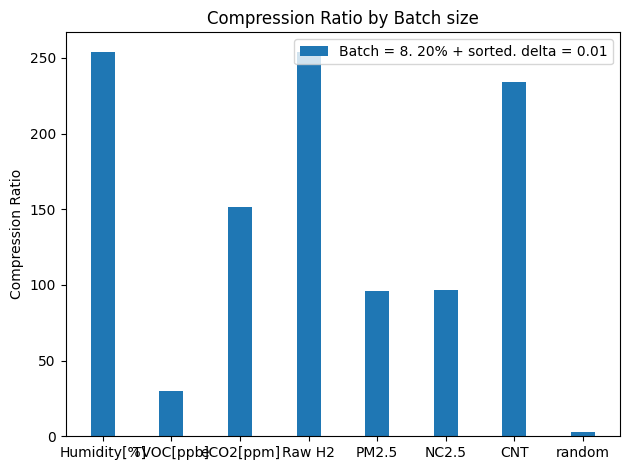

dict_keys(['Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw H2', 'PM2.5', 'NC2.5', 'CNT', 'random'])


In [801]:
plot_batch_comparison_cr(0)

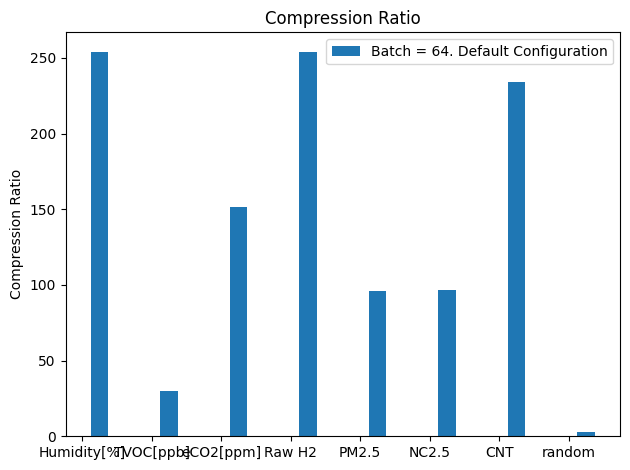

In [804]:
data = get_table_stats(folder_name[0], "Autoencoder_Data/measurements_train_with_20/", base_columns)
names = list(data.keys())
values1 = list(i[3] for i in data.values())
values2 = list(i[4] for i in data.values())
values3 = list(i[5] for i in data.values())

x = np.arange(len(names))
width = 0.25

fig, ax = plt.subplots()
# rects1 = ax.bar(x, values1, width, label='Zstd')
rects2 = ax.bar(x + width, values2, width, label='Batch = 64. Default Configuration')
# rects3 = ax.bar(x + 2*width, values3, width, label='Zstd. lvl=22')

ax.set_ylabel('Compression Ratio')
ax.set_title('Compression Ratio')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()

fig.tight_layout()
plt.show()

In [783]:
for column in base_columns:
    print(column, get_compression_ratio_rawcnt(f"data/table_0_smoke_detection/{column}/", column+"_test_20.txt"))

Humidity[%] 254.17374762206722
TVOC[ppb] 29.722433165439753
eCO2[ppm] 151.3144582861457
Raw H2 254.17374762206722
PM2.5 95.78166147953077
NC2.5 96.94163235650278
CNT 233.9754816112084
random 2.817852268224313


In [396]:
data = []
for i in range(1):  #len(folder_name)):
    data.append(get_table_stats(folder_name[i], "Autoencoder_Data/measurements_batch_8/", columns[i]))

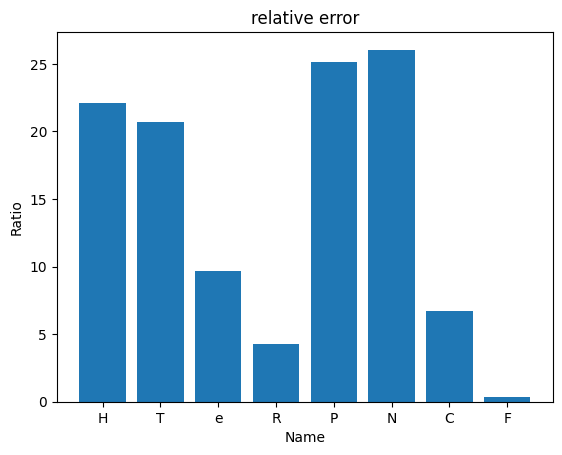

dict_keys(['Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw H2', 'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'CNT', 'Fire Alarm'])


In [397]:
build_plot_re(data[0])
print(data[0].keys())

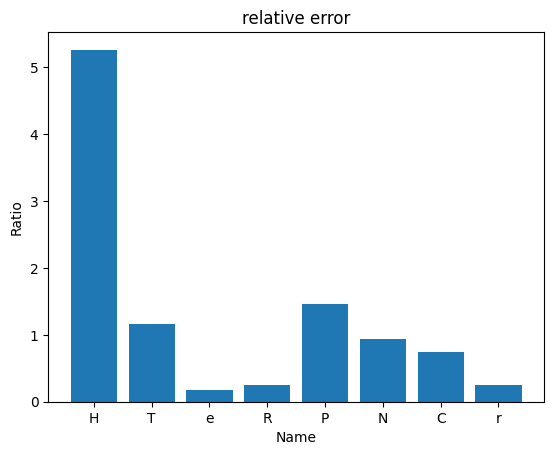

{'Humidity[%]': [5.260729099374978, 3.442847121810907, 826.0646797717185],
 'TVOC[ppb]': [1.1584793250088823, 3.180598595816495, 96.59790778767918],
 'eCO2[ppm]': [0.17337758650178348, 3.963376315741693, 491.77198942997364],
 'Raw H2': [0.2497060865044737, 5.435416895453325, 826.0646797717185],
 'PM2.5': [1.4561731759665049, 3.339933703267787, 311.290399808475],
 'NC2.5': [0.9428407824207357, 3.32074226969519, 315.06030515863404],
 'CNT': [0.7457514977728019, 3.6113912677262126, 760.4203152364274],
 'random': [0.24749674658588602, 1.7904055305840434, 6.838619252388571]}

In [549]:
build_plot_re(get_table_stats(folder_name[0], "AutoEncoder_Data/measurements_train_20_delta/", base_columns))
get_table_stats(folder_name[0], "AutoEncoder_Data/measurements_train_20_delta/", base_columns)

In [321]:
def get_vector_one(path_to_table, file_name):
    with open(os.path.join(path_to_table, file_name)) as f1:
        lines1 = f1.readlines()
    array1 = np.array([float(line) for line in lines1])
    return array1

In [793]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distributions(vector, N, mode='individual'):
    # Split the vector into N equal parts
    split_data = np.array_split(vector, N)

    if mode == 'individual':
        # Create a figure with N subplots
        fig, axs = plt.subplots(N, figsize=(5, 5*N))

        # For each part, plot the distribution on a separate subplot
        for i, data in enumerate(split_data):
            sns.histplot(data, ax=axs[i], kde=True)
            axs[i].set_title(f'Distribution of part {i+1}')

    elif mode == 'together':
        # Create a figure
        fig, ax = plt.subplots(figsize=(10, 5))

        # For each part, plot the distribution on the same plot
        for i, data in enumerate(split_data):
            sns.histplot(data, ax=ax, kde=True, label=f'Part {i+1}')

        # Add a legend
        ax.legend()

    else:
        print(f"Invalid mode: {mode}. Use 'individual' or 'together'.")

    # Display the plots
    plt.tight_layout()
    plt.show()

# Example usage:
# vector = np.random.rand(1000)
# plot_distributions(vector, 5, 'individual')
# plot_distributions(vector, 5, 'together')


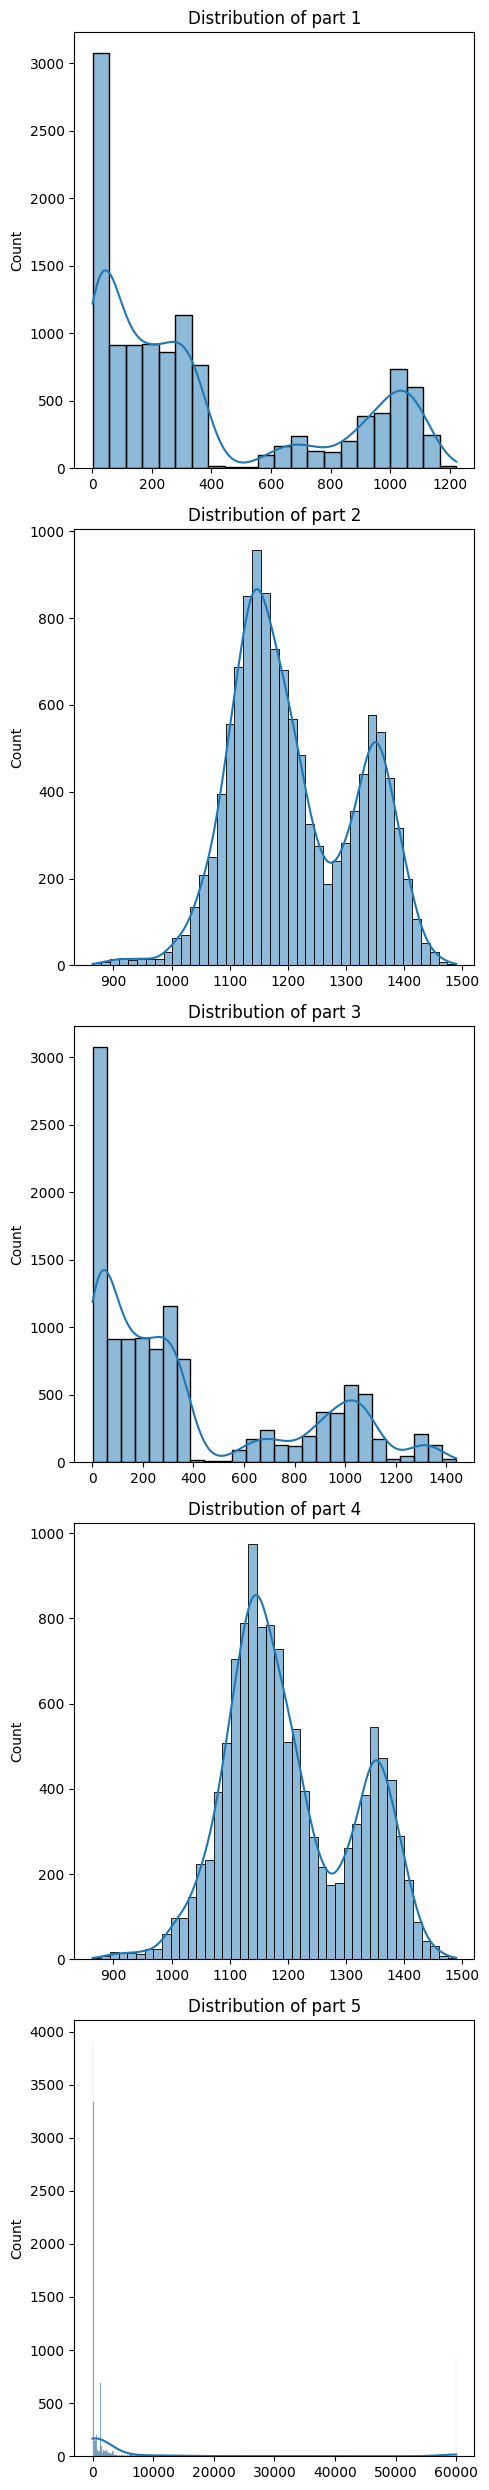

In [799]:
plot_distributions(get_vector_one("data/table_0_smoke_detection/TVOC[ppb]", "TVOC[ppb].txt"), 5, 'individual')

In [808]:
import seaborn as sns
import numpy as np

import numpy as np


def remove_high_values(arr, X):
    # Calculate the median of the input array
    median = np.median(arr)

    # Calculate the threshold value
    threshold = median * (1 + X / 100)

    # Create a boolean mask to filter out values that are higher than the threshold
    mask = arr <= threshold

    # Return a new array with only the values that are not higher than the threshold
    return arr[mask]


def data_distr(ind, border, type, description):
    print(base_columns[ind])
    # Generate some random data
    data = get_vector_one(f"{path_to_folder}{folder_name[0]}/{base_columns[ind]}/", base_columns[ind] + type + ".txt")
    data = remove_high_values(data, border)
    print(data)
    # Create a histogram
    sns.histplot(data, label=description)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Humidity[%]
[49.2  49.12 49.09 ... 15.84 16.04 16.52]
Humidity[%]
[57.36 56.67 55.96 ... 49.39 49.33 49.24]


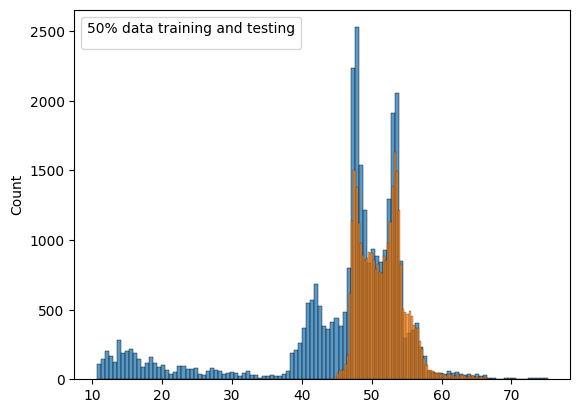

In [811]:
plt.legend(title="50% data training and testing")
data_distr(0, 100000, "_test", "test")
data_distr(0, 100000, "_train", "train")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Humidity[%]
[52.5  52.6  52.69 ... 15.84 16.04 16.52]
Humidity[%]
[57.36 56.67 55.96 ... 52.14 52.27 52.35]


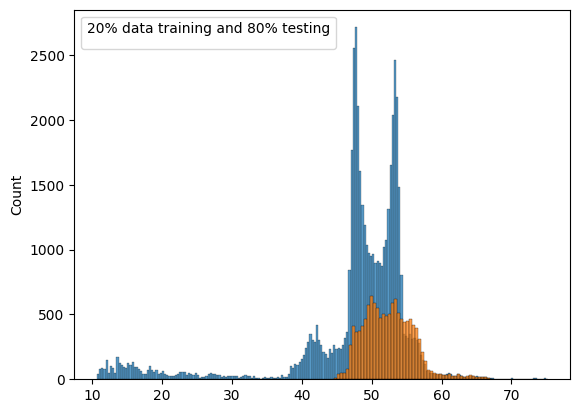

In [814]:
plt.legend(title="20% data training and 80% testing")
data_distr(0, 10000, "_test_20", "test_20")
data_distr(0, 20000, "_train_20", "train_20")

Humidity[%]
[57.36 56.67 55.96 ... 52.14 52.27 52.35]


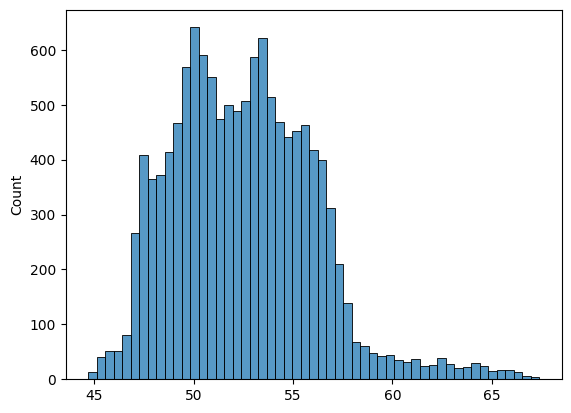

In [682]:
data_distr(0, 10000, "_train_20")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TVOC[ppb]
[165. 154. 150. ... 627. 638. 643.]
TVOC[ppb]
[ 30.  36.  20. ... 156. 165. 162.]


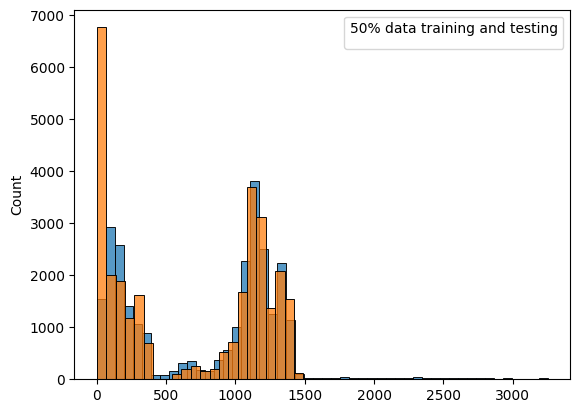

In [816]:
plt.legend(title="50% data training and testing")
data_distr(1, 200, "_test", "test")
data_distr(1, 200, "_train", "train")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TVOC[ppb]
[1076. 1109.  992. ...  627.  638.  643.]
TVOC[ppb]
[  30.   36.   20. ... 1113. 1074. 1061.]


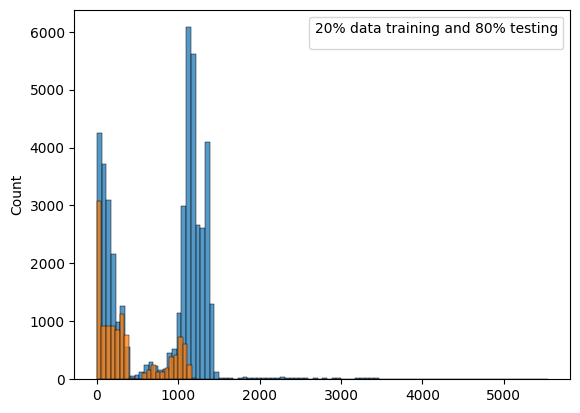

In [817]:
plt.legend(title="20% data training and 80% testing")
data_distr(1, 400, "_test_20", "test")
data_distr(1, 4000, "_train_20", "train")

TVOC[ppb]
[  30.   36.   20. ... 1113. 1074. 1061.]


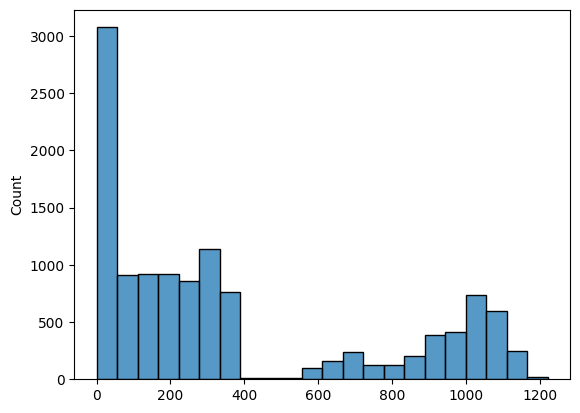

In [698]:
data_distr(1, 2000, "_train_20")

eCO2[ppm]
[400. 400. 400. ... 400. 400. 400.]
eCO2[ppm]
[400. 400. 400. ... 400. 400. 400.]


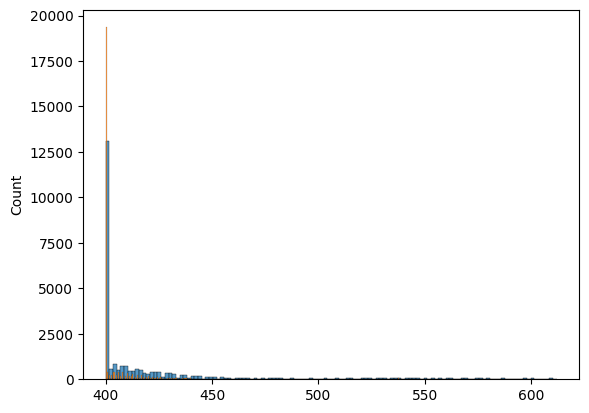

In [717]:
data_distr(2, 50, "_test")
data_distr(2, 50, "_train")

eCO2[ppm]
[560. 580. 561. ... 400. 400. 400.]
eCO2[ppm]
[400. 400. 400. ... 569. 566. 563.]


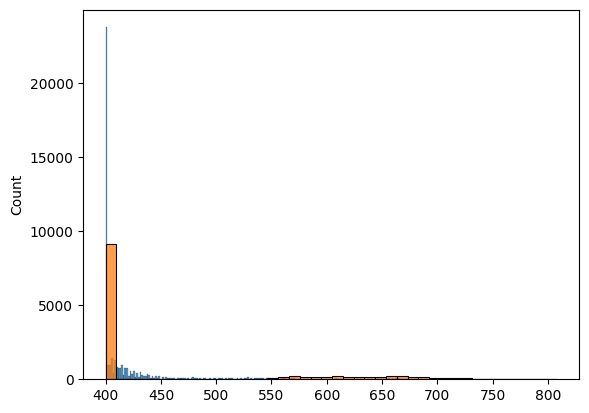

In [715]:
data_distr(2, 100, "_test_20")
data_distr(2, 100, "_train_20")

Raw H2
[13167. 13170. 13167. ... 13725. 13712. 13696.]
Raw H2
[12306. 12345. 12374. ... 13173. 13166. 13167.]


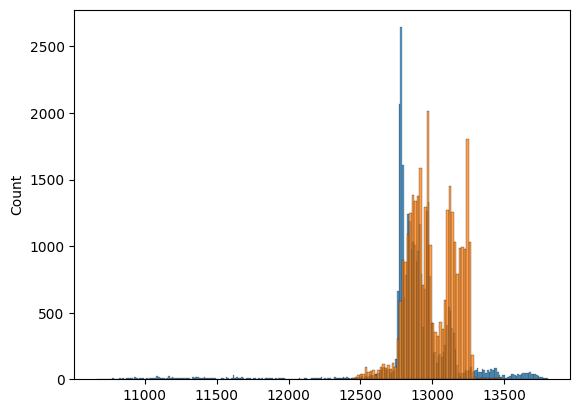

In [718]:
data_distr(3, 20, "_test")
data_distr(3, 20, "_train")

Raw H2
[12827. 12823. 12829. ... 13725. 13712. 13696.]
Raw H2
[12306. 12345. 12374. ... 12821. 12824. 12829.]


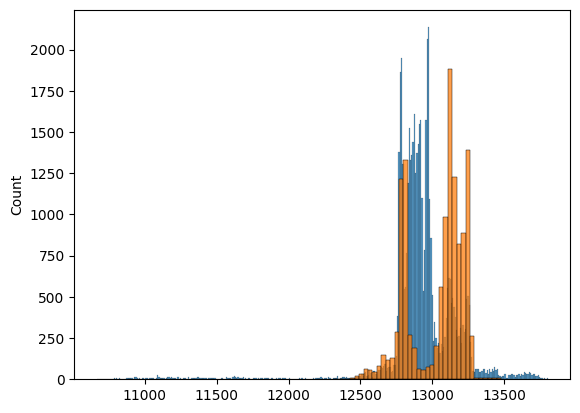

In [719]:
data_distr(3, 20, "_test_20")
data_distr(3, 20, "_train_20")

PM2.5
[0.92 0.91 0.89 ... 0.6  0.59 0.59]
PM2.5
[3.51 3.38 3.11 ... 0.97 0.97 0.96]


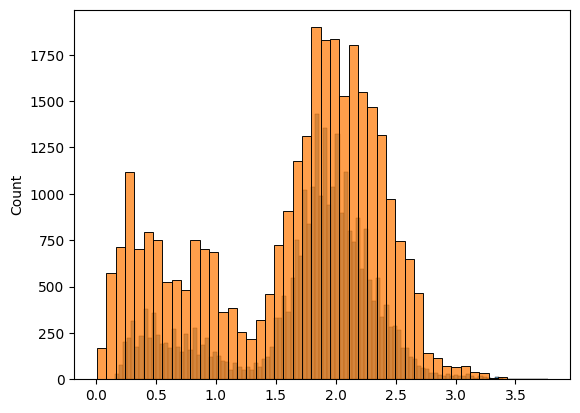

In [720]:
data_distr(4, 100, "_test")
data_distr(4, 100, "_train")

PM2.5
[1.94 1.95 1.99 ... 0.6  0.59 0.59]
PM2.5
[3.78 3.71 3.51 ... 1.95 1.93 1.93]


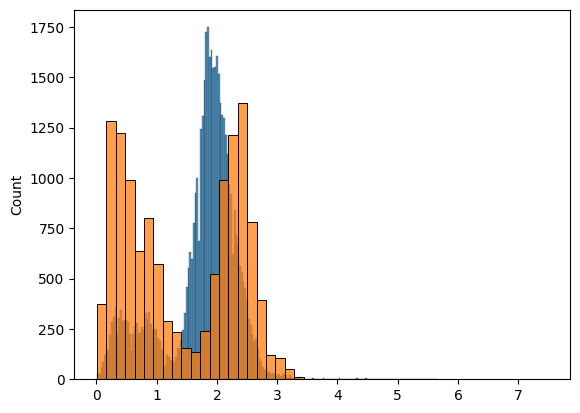

In [724]:
data_distr(4, 200, "_test_20")
data_distr(4, 1000, "_train_20")

NC2.5
[0.021 0.021 0.022 ... 0.014 0.014 0.014]
NC2.5
[0.122 0.105 0.097 ... 0.019 0.02  0.02 ]


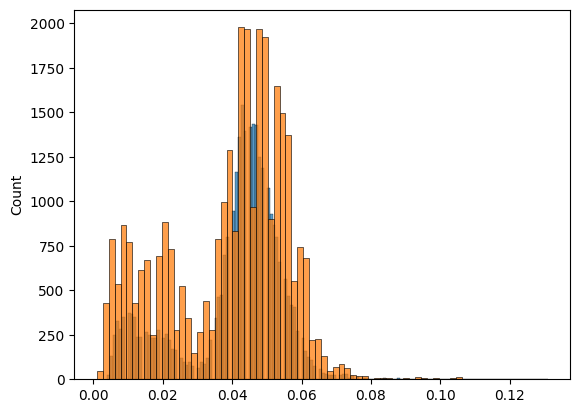

In [722]:
data_distr(5, 200, "_test")
data_distr(5, 200, "_train")

CNT
[6320. 6321. 6322. ... 5741. 5742. 5743.]
CNT
[1.000e+00 2.000e+00 3.000e+00 ... 6.317e+03 6.318e+03 6.319e+03]


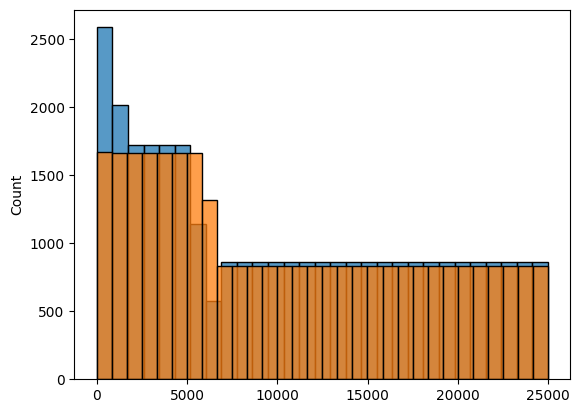

In [730]:
data_distr(6, 8000, "_test")
data_distr(6, 8000, "_train")

CNT
[12526. 12527. 12528. ...  5741.  5742.  5743.]
CNT
[1.0000e+00 2.0000e+00 3.0000e+00 ... 1.2523e+04 1.2524e+04 1.2525e+04]


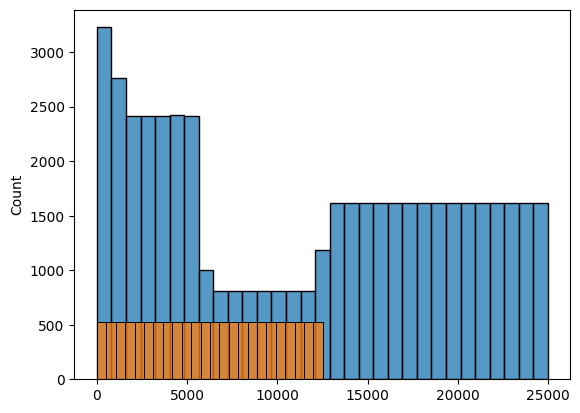

In [733]:
data_distr(6, 8000, "_test_20")
data_distr(6, 8000, "_train_20")

In [691]:
# generate_random_and_save(f"{path_to_folder}{folder_name[0]}/random/random_train.txt", 30000, 10, 45000)

random
[22491.97139952 41438.74634705 35548.73296417 ... 25746.73158738
  9833.19293198 41342.1917536 ]
random
[29030.77068569 22750.58812453 31784.71923165 ... 33056.38153752
  3223.09297913  3241.89733412]


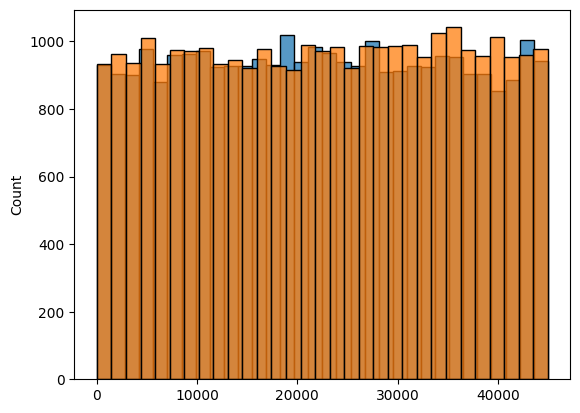

In [734]:
data_distr(7, 1000, "_test")
data_distr(7, 1000, "_train")

random
[12119.92585158  9547.78938028 43109.14284173 ...  5381.09186649
  1539.46057017 22358.25515042]
random
[14944.67054845  7556.64334282 19327.14594048 ... 33364.85974886
 20098.79402315  5780.41752402]


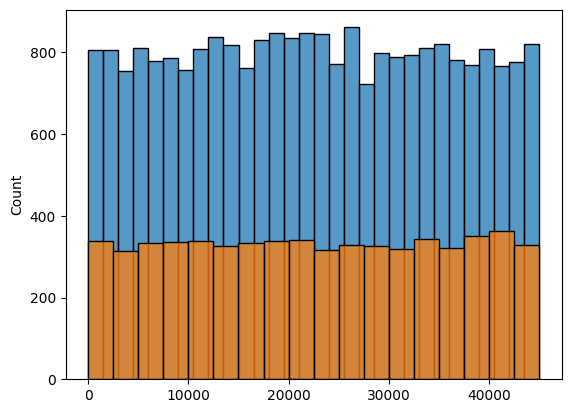

In [735]:
data_distr(7, 1000, "_test_20")
data_distr(7, 1000, "_train_20")

In [616]:
def get_time_from_bench(path_to_file):
    with open(path_to_file, 'r') as file:
        first_line = file.readline().strip()
        parts = first_line.split()
        if len(parts) == 2:
            return float(parts[1])
        else:
            raise ValueError("Invalid format in the first line")

In [650]:
test_config = ["measurements/", "measurements_batch_32/", "measurements_batch_16/", "measurements_batch_8/",
               "measurements_train_with_20/", "measurements_sorted_train_with_20/", "measurements_train_20_delta/"]

decompressing_time = []

for config in test_config:
    print(config)
    columns_time = []
    for column in base_columns:
        columns_time.append(get_time_from_bench(
            f"data/table_0_smoke_detection/{column}/Autoencoder_Data/{config}/benchmarks_decompression.txt"))
        print(column, columns_time[len(columns_time) - 1])
    decompressing_time.append(columns_time)
    print('================')

measurements/
Humidity[%] 0.3081700801849365
TVOC[ppb] 0.29872584342956543
eCO2[ppm] 0.2826838493347168
Raw H2 0.26712965965270996
PM2.5 0.2776370048522949
NC2.5 0.3281574249267578
CNT 0.27630186080932617
random 0.29350829124450684
measurements_batch_32/
Humidity[%] 0.2824132442474365
TVOC[ppb] 0.2658107280731201
eCO2[ppm] 0.31304049491882324
Raw H2 0.2656593322753906
PM2.5 0.2715284824371338
NC2.5 0.5809509754180908
CNT 0.28549909591674805
random 0.28384971618652344
measurements_batch_16/
Humidity[%] 0.725170373916626
TVOC[ppb] 0.6279537677764893
eCO2[ppm] 0.7232723236083984
Raw H2 0.5313229560852051
PM2.5 0.579028844833374
NC2.5 0.5810756683349609
CNT 0.2941172122955322
random 0.3444638252258301
measurements_batch_8/
Humidity[%] 0.31809473037719727
TVOC[ppb] 0.2980339527130127
eCO2[ppm] 0.31160712242126465
Raw H2 0.26784253120422363
PM2.5 0.29120922088623047
NC2.5 0.3093268871307373
CNT 0.2848386764526367
random 0.29446887969970703
measurements_train_with_20/
Humidity[%] 0.8309471607

In [654]:
import matplotlib.pyplot as plt
import numpy as np


def plot_batch_comparison_time(ind):
    data = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements/", base_columns)

    data1 = decompressing_time[0]
    data2 = decompressing_time[3]
    data3 = decompressing_time[4]
    data4 = decompressing_time[5]
    data5 = decompressing_time[6]
    # data5 = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements_batch_8/", base_columns)
    # data4 = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements_train_with_20/", base_columns)
    # data5 = get_table_stats(folder_name[ind], "Autoencoder_Data/measurements_batch_4_train_20/", base_columns)
    # data6 = get_table_stats(folder_name[ind], "AutoEncoder_Data/measurements_sorted/", base_columns)

    names = list(data.keys())
    values0 = data1
    values1 = data2
    values2 = data3
    values3 = data4
    values4 = data5
    # values4 = list(i[0] for i in data4.values())
    # values5 = list(i[0] for i in data5.values())
    # values6 = list(i[0] for i in data6.values())
    # values7 = list(i[0] for i in data7.values())

    x = np.arange(len(names))
    width = 0.15

    fig, ax = plt.subplots()
    rects0 = ax.bar(x, values0, width, label='Batch = 64. Default')
    rects1 = ax.bar(x + width, values1, width, label='Batch = 8')
    rects2 = ax.bar(x + 2 * width, values2, width, label='Batch = 8. Train on 20%')
    rects3 = ax.bar(x + 3 * width, values3, width, label='Batch = 8. Train on 20% + sorted')
    rects4 = ax.bar(x + 4 * width, values4, width, label='Batch = 8. 20% + sorted. delta = 0.01')
    # rects4 = ax.bar(x + 2*width, values4, width, label='Batch = 8. Train = 20%')
    # rects5 = ax.bar(x + 3*width, values5, width, label='Batch = 4. Train = 20%')
    # rects6 = ax.bar(x + 4*width, values6, width, label='Batch = 8. Train Sorted ')
    # rects7 = ax.bar(x + 3*width, values7, width, label='Batch = 8. Train Sorted. Test not')

    ax.set_ylabel('Time in sec')
    ax.set_title('decompressing Time by Configuration')
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.legend()

    fig.tight_layout()
    plt.show()

    print(data.keys())

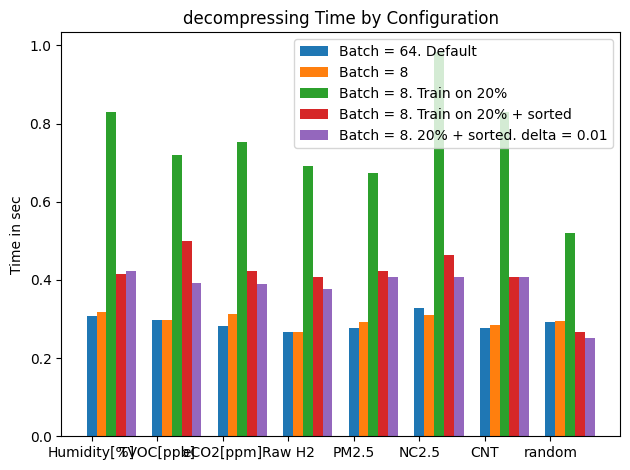

dict_keys(['Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw H2', 'PM2.5', 'NC2.5', 'CNT', 'random'])


In [655]:
plot_batch_comparison_time(0)

0